In [1]:
import os
import numpy as np 
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage
import cv2
import random
import json
import gc

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
import torch.backends.cudnn
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose



from tqdm import tqdm
from pathlib import Path

from skimage.morphology import label

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_image_dir = '/home/arti/DL/Datasets/test_v2/Images'

In [4]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [3]:
masks = pd.read_csv('/home/arti/DL/Datasets/test_ship_segmentations_v3.csv')
#masks = masks.iloc[10000:12000]
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], 'unique images found')
print('\nmasks:')
masks.sample(3)

69632 masks found
57767 unique images found

masks:


,ImageId,EncodedPixels
64500,9a5507e4a.jpg,25580 1 26346 4 27112 6 27878 9 28644 11 29411...
15983,1d25bf017.jpg,264422 1 265189 3 265956 5 266723 7 267490 9 2...
36174,40e0b425b.jpg,NaN


In [37]:
rle = masks.loc[3].EncodedPixels

In [38]:
rle

'101361 1 102128 3 102896 4 103663 6 104430 9 105198 10 105209 1 105965 14 106732 14 107500 14 108267 14 109034 14 109802 14 110569 14 111336 14 112104 14 112871 14 113638 14 114406 14 115173 14 115940 14 116708 14 117475 14 118242 14 119010 14 119777 14 120544 14 121312 14 122079 14 122846 14 123614 14 124381 14 125150 12 125920 10 126689 8 127459 5 128228 4 128998 1'

In [41]:
mask = rle_decode(rle, shape=(768, 768))
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

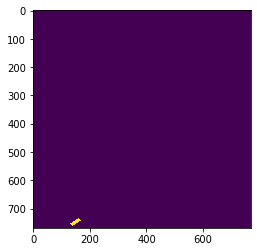

In [42]:
plt.imshow(mask)

In [44]:
rle_encoded = rle_encode(mask)
rle_encoded

'101361 1 102128 3 102896 4 103663 6 104430 9 105198 10 105209 1 105965 14 106732 14 107500 14 108267 14 109034 14 109802 14 110569 14 111336 14 112104 14 112871 14 113638 14 114406 14 115173 14 115940 14 116708 14 117475 14 118242 14 119010 14 119777 14 120544 14 121312 14 122079 14 122846 14 123614 14 124381 14 125150 12 125920 10 126689 8 127459 5 128228 4 128998 1'

In [45]:
rle_encoded == rle

True